In [77]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
import joblib


In [78]:
all_data = pd.read_csv("../data/raw/mbajk_dataset.csv")
print(all_data.head())

   Unnamed: 0                       date  temperature  relative_humidity  \
0           0  2023-06-25 19:07:30+00:00         25.1                 45   
1           1  2023-06-25 20:25:41+00:00         24.2                 43   
2           2  2023-06-25 20:12:20+00:00         24.2                 43   
3           3  2023-06-25 19:33:48+00:00         24.2                 43   
4           4  2023-06-25 19:55:29+00:00         24.2                 43   

   dew_point  apparent_temperature  precipitation_probability  rain  \
0       12.4                  24.7                        0.0   0.0   
1       10.9                  23.3                        NaN   0.0   
2       10.9                  23.3                        0.0   0.0   
3       10.9                  23.3                        0.0   0.0   
4       10.9                  23.3                        NaN   0.0   

   surface_pressure  bike_stands  available_bike_stands  
0             984.3           22                      8  


In [79]:
all_data['date'] = pd.to_datetime(all_data['date'])
all_data.sort_values(by='date', inplace=True)


In [80]:
all_data['date'] = pd.to_datetime(all_data['date'])
all_data.sort_values(by='date', inplace=True)
features = ['available_bike_stands', 'temperature', 'relative_humidity',
             'apparent_temperature', 'dew_point', 'precipitation_probability',
               'surface_pressure','bike_stands', 'rain']
all_data = all_data[['date'] + features]

In [81]:
all_data.isnull().sum()

date                            0
available_bike_stands           0
temperature                  1869
relative_humidity               0
apparent_temperature            0
dew_point                       0
precipitation_probability    1308
surface_pressure                0
bike_stands                     0
rain                         2804
dtype: int64

In [82]:
missing_values = all_data.isnull().sum()

print(missing_values)
features_with_missing_values = missing_values[missing_values > 0].index
    
all_data = all_data.copy()
columns_with_missing_values = all_data.columns[all_data.isnull().any()].tolist()
columns_complete_values = all_data.drop(columns_with_missing_values + ["date"], axis=1).columns.tolist()

missing_df = all_data[all_data.isnull().any(axis=1)]
complete_df = all_data.dropna()

for column in columns_with_missing_values:
    X = complete_df[columns_complete_values]
    y = complete_df[column]
    
    model = RandomForestRegressor()
    model.fit(X, y)
    
    missing_X = missing_df[columns_complete_values]
    predictions = model.predict(missing_X)
    
    all_data.loc[missing_df.index, column] = predictions

missing_values = all_data.isnull().sum()

print(missing_values)

multivariate_series = np.array(all_data[features].values)

date                            0
available_bike_stands           0
temperature                  1869
relative_humidity               0
apparent_temperature            0
dew_point                       0
precipitation_probability    1308
surface_pressure                0
bike_stands                     0
rain                         2804
dtype: int64


date                         0
available_bike_stands        0
temperature                  0
relative_humidity            0
apparent_temperature         0
dew_point                    0
precipitation_probability    0
surface_pressure             0
bike_stands                  0
rain                         0
dtype: int64


In [83]:

all_data.set_index('date', inplace=True)

# Izberemo časovni interval (npr. 1 ura)
time_interval = '1h'

# Agregiramo podatke na izbrani časovni interval
aggregated_data = all_data.resample(time_interval).mean()

# Ponovno nastavimo stolpec 'date' kot stolpec v dataframe-u
aggregated_data.reset_index(inplace=True)
all_data = aggregated_data
all_data.dropna(inplace=True)
all_data.isnull().sum()

date                         0
available_bike_stands        0
temperature                  0
relative_humidity            0
apparent_temperature         0
dew_point                    0
precipitation_probability    0
surface_pressure             0
bike_stands                  0
rain                         0
dtype: int64

In [84]:
all_data.size

23440

In [85]:
def plot_histograms(df):
    numeric_columns = df.select_dtypes(include=['number'])
    numeric_columns.hist(bins=20, figsize=(20, 20))
    plt.title("Histograms of numerical columns")
    plt.show()

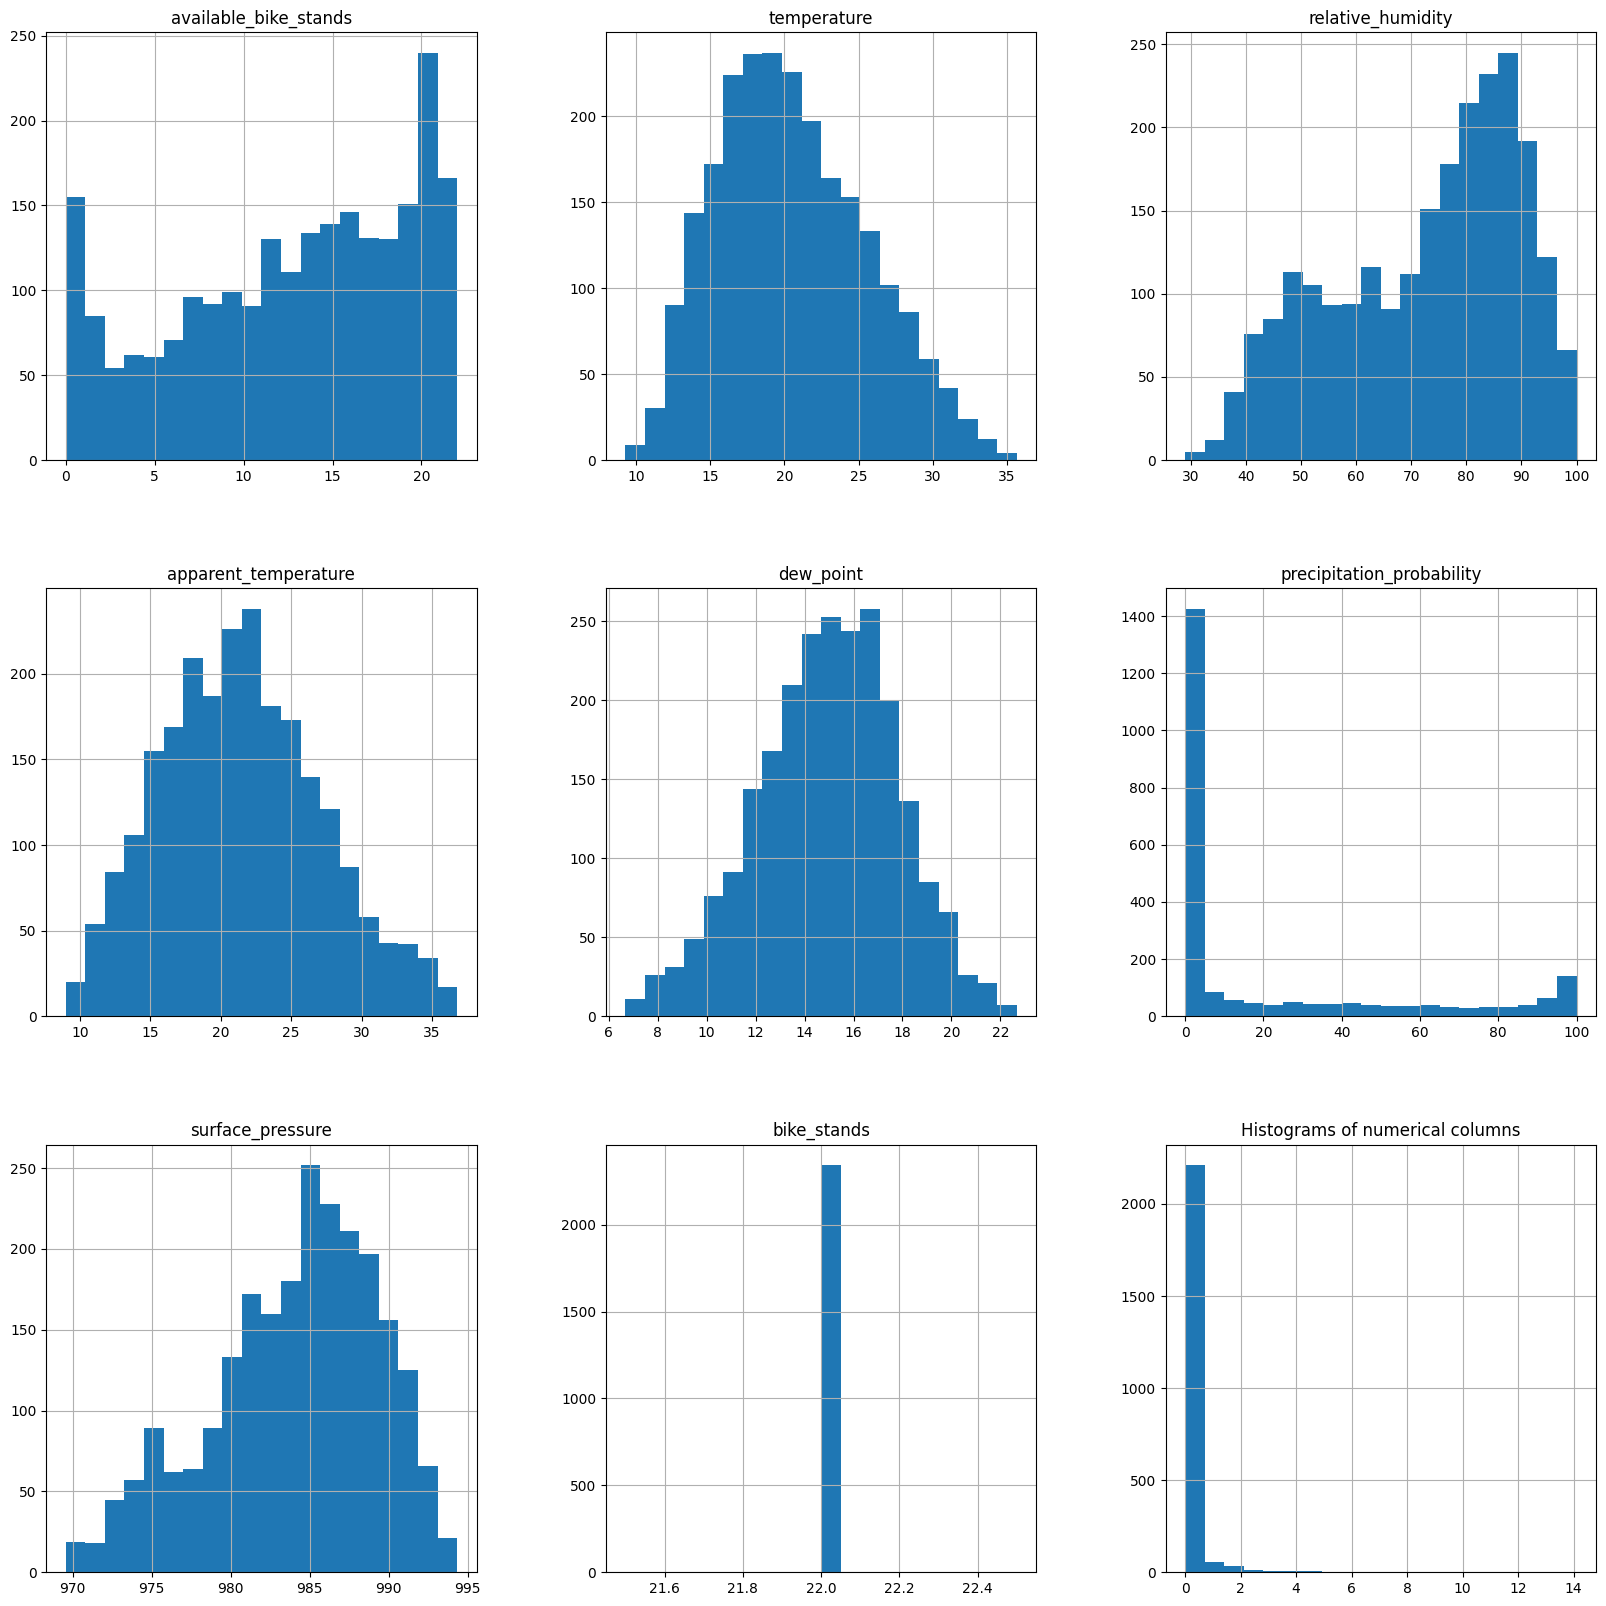

In [86]:
plot_histograms(all_data)

In [87]:
def printSkew():
  skewness_info = []
  for column in all_data.columns[1:]:
      skew = all_data[column].skew()
      skewness_info.append((column, skew))

  # Pretvori seznam v DataFrame za lažje prikazovanje
  skewness_df = pd.DataFrame(skewness_info, columns=['Column Name', 'Skewness'])

  # Izpišite oznako stolpca in njegovo poševnost
  print(skewness_df)

printSkew()

                 Column Name  Skewness
0      available_bike_stands -0.423455
1                temperature  0.364716
2          relative_humidity -0.500495
3       apparent_temperature  0.263880
4                  dew_point -0.211922
5  precipitation_probability  1.323155
6           surface_pressure -0.519311
7                bike_stands  0.000000
8                       rain  9.577932


In [88]:
left_skew_columns = ["surface_pressure"]
for col in left_skew_columns:
    all_data[col] = np.square(all_data[col])

In [89]:
right_skew_columns = ["rain", "precipitation_probability"]
for col in right_skew_columns:
    all_data[col] = np.log(all_data[col]+1 )

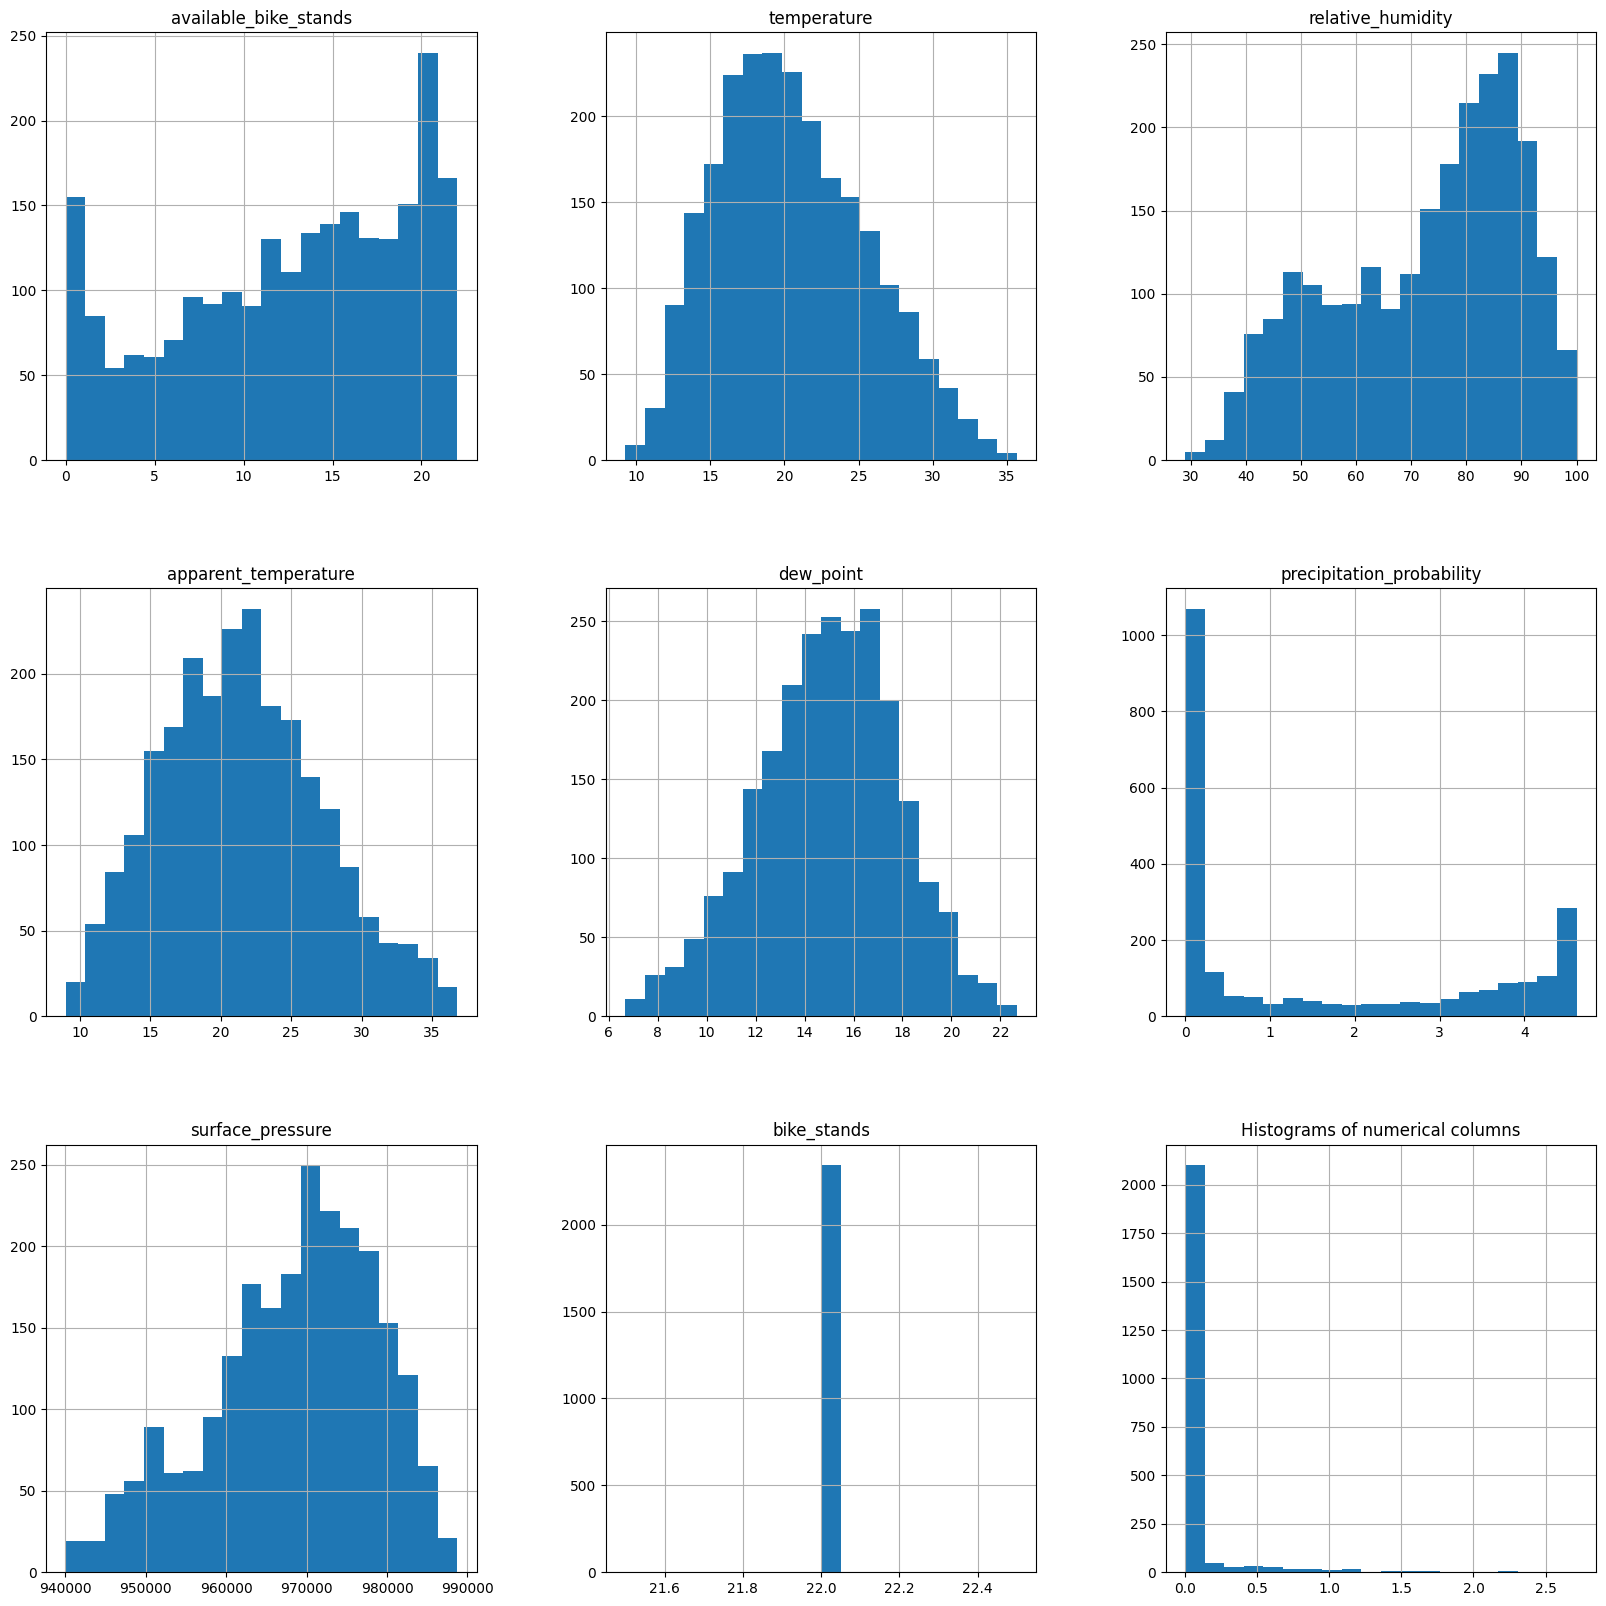

In [90]:
plot_histograms(all_data)


In [91]:
target = all_data['available_bike_stands']
target_feature = all_data.drop('date', axis=1)

info_gains = mutual_info_regression(target_feature.drop('available_bike_stands', axis=1), target)

info_gain_df = pd.DataFrame({'Feature': target_feature.columns.drop('available_bike_stands'), 'Information_Gain': info_gains})
info_gain_df = info_gain_df.sort_values(by='Information_Gain', ascending=False)

print(info_gain_df)

threshold = 0.1
selected_features = info_gain_df[info_gain_df['Information_Gain'] >= threshold]['Feature']

print("Selected Features:")
print(selected_features)

                     Feature  Information_Gain
5           surface_pressure          0.169867
1          relative_humidity          0.095533
0                temperature          0.086720
2       apparent_temperature          0.079790
4  precipitation_probability          0.056430
7                       rain          0.037229
3                  dew_point          0.034215
6                bike_stands          0.030356
Selected Features:
5    surface_pressure
Name: Feature, dtype: object


In [92]:
selected_features

5    surface_pressure
Name: Feature, dtype: object

In [93]:
learn_features = all_data[ ['available_bike_stands']+ list(selected_features)]
learn_features = learn_features.values

In [94]:
train_size = len(learn_features) - 384 - 48
train_data, test_data = learn_features[:train_size], learn_features[train_size:]


In [95]:
train_data.shape, test_data.shape

((1912, 2), (432, 2))

In [96]:
train_stands = np.array(train_data[:,0])
test_stands = np.array(test_data[:,0])
stands_scaler = MinMaxScaler()
train_stands_normalized = stands_scaler.fit_transform(train_stands.reshape(-1, 1))
test_stands_normalized = stands_scaler.transform(test_stands.reshape(-1, 1))

train_final_stands = np.array(learn_features[:, 0])
train_final_stands_normalized = stands_scaler.fit_transform(train_final_stands.reshape(-1, 1))

In [97]:
train_other = np.array(train_data[:,1:])
test_other = np.array(test_data[:,1:])
other_scaler = MinMaxScaler()
train_other_normalized = other_scaler.fit_transform(train_other)
test_other_normalized = other_scaler.transform(test_other)

train_final_other = np.array(learn_features[:, 1:])
train_final_other_normalized = other_scaler.fit_transform(train_final_other)


In [98]:
train_normalized = np.column_stack([train_stands_normalized, train_other_normalized])
test_normalized = np.column_stack([test_stands_normalized, test_other_normalized])

train_final_normalized = np.column_stack([train_final_stands_normalized, train_final_other_normalized])

In [99]:
def create_multivariate_dataset_with_steps(time_series, look_back=1, step=1):
    X, y = [], []
    for i in range(0, len(time_series) - look_back, step):
        X.append(time_series[i:(i + look_back), :])
        y.append(time_series[i + look_back, 0]) 
    return np.array(X), np.array(y)

look_back = 48
step = 1

X_train, y_train = create_multivariate_dataset_with_steps(train_normalized, look_back, step)
X_test, y_test = create_multivariate_dataset_with_steps(test_normalized, look_back, step)

X_final, y_final = create_multivariate_dataset_with_steps(train_final_normalized, look_back, step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

X_final = X_final.reshape(X_final.shape[0], X_final.shape[2], X_final.shape[1])


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (1864, 2, 48)
X_test shape: (384, 2, 48)


In [100]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=32))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1))
    return model

In [101]:
def train_and_plot_model(model, X_train, y_train, epochs=50):
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=1)
    
    # Izris zgodovine učenja
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Learning History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [102]:
input_shape = (X_train.shape[1], X_train.shape[2])

Epoch 1/30
47/47 [==============================] - 5s 42ms/step - loss: 0.1185 - val_loss: 0.1037
Epoch 2/30
47/47 [==============================] - 0s 6ms/step - loss: 0.0633 - val_loss: 0.0686
Epoch 3/30
47/47 [==============================] - 0s 6ms/step - loss: 0.0483 - val_loss: 0.0515
Epoch 4/30
47/47 [==============================] - 0s 8ms/step - loss: 0.0385 - val_loss: 0.0436
Epoch 5/30
47/47 [==============================] - 0s 7ms/step - loss: 0.0258 - val_loss: 0.0293
Epoch 6/30
47/47 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0246
Epoch 7/30
47/47 [==============================] - 0s 6ms/step - loss: 0.0169 - val_loss: 0.0272
Epoch 8/30
47/47 [==============================] - 0s 7ms/step - loss: 0.0166 - val_loss: 0.0243
Epoch 9/30
47/47 [==============================] - 0s 7ms/step - loss: 0.0146 - val_loss: 0.0245
Epoch 10/30
47/47 [==============================] - 0s 7ms/step - loss: 0.0154 - val_loss: 0.0229
Epoch 11/30
47/47 

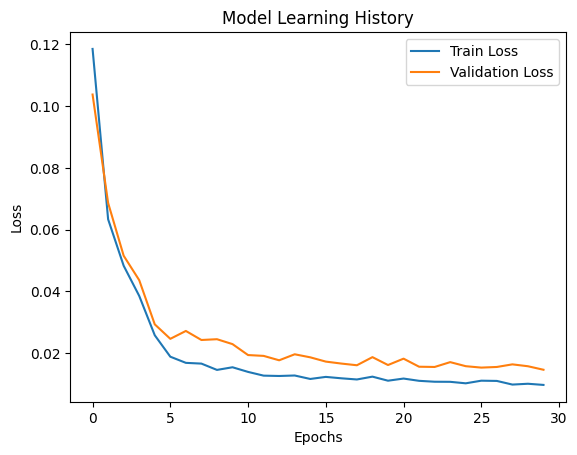

In [103]:
lstm_model_adv = build_lstm_model(input_shape)
train_and_plot_model(lstm_model_adv, X_train, y_train, epochs=30)

In [104]:
y_test_pred_lstm_adv = lstm_model_adv.predict(X_test)

12/12 [==============================] - 1s 5ms/step


In [105]:
y_test_true = stands_scaler.inverse_transform(y_test.reshape(-1, 1))

y_test_pred_lstm_adv = stands_scaler.inverse_transform(y_test_pred_lstm_adv)

In [106]:
def calculate_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    return mae, mse, evs

In [107]:
lstm_mae_adv, lstm_mse_adv, lstm_evs_adv = calculate_metrics(y_test_true, y_test_pred_lstm_adv)
print("\nLSTM Model Metrics:")
print(f"MAE: {lstm_mae_adv}, MSE: {lstm_mse_adv}, EVS: {lstm_evs_adv}")


LSTM Model Metrics:
MAE: 2.2676091447565163, MSE: 10.313774501998411, EVS: 0.7918046025734858


(384,)


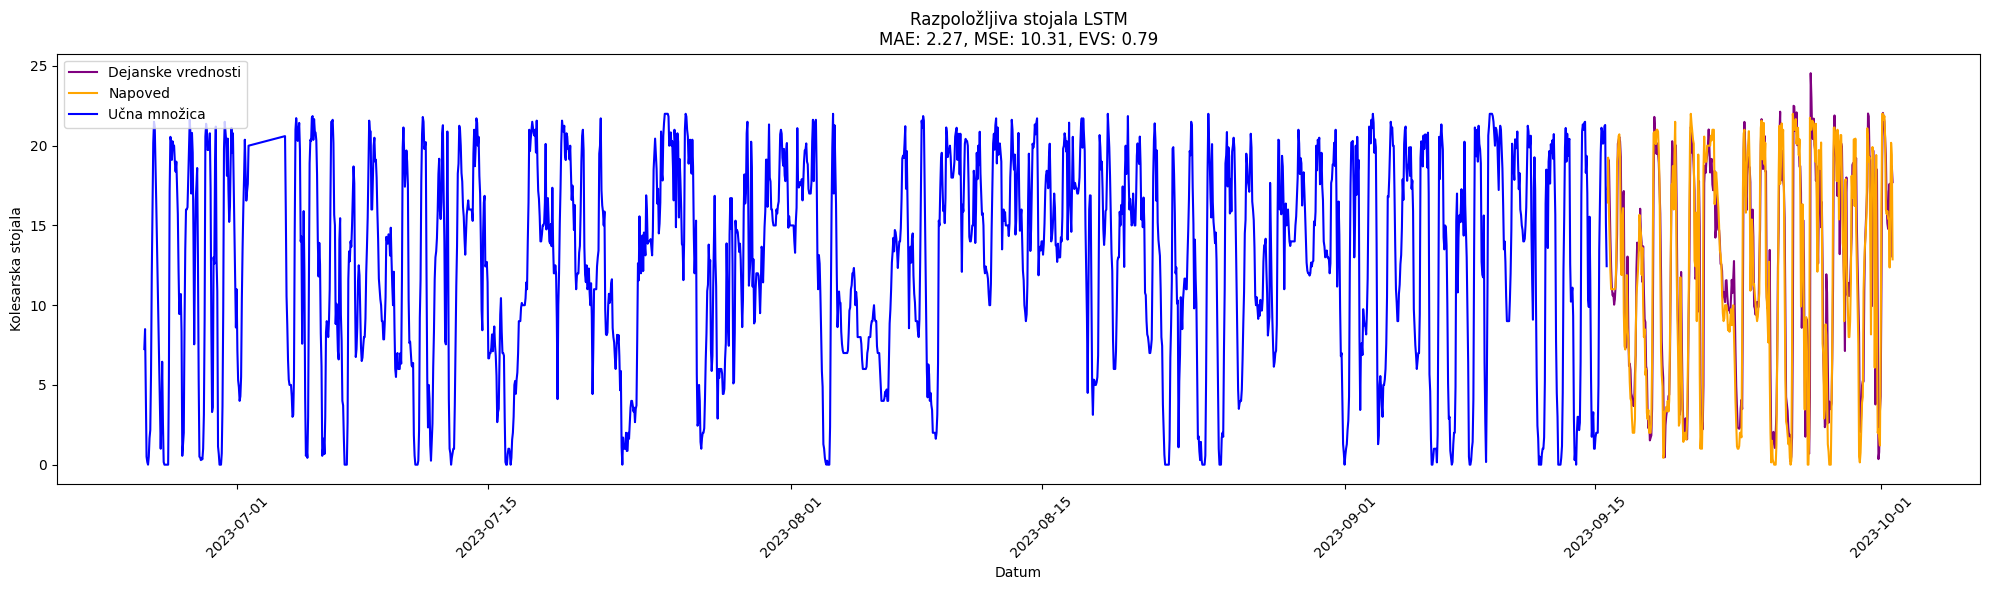

In [108]:
dates = all_data['date'][:-look_back][-len(y_test):]
train_dates =  all_data['date'][:len(train_data)]


print(dates.shape)
# Function to plot a comparison between actual values and predictions for a given model
def plot_comparison(train_dates, train_data, test_dates, y_pred_inverse, y_test_inverse, model_name, color1, color2, mae, mse, evs):
    plt.figure(figsize=(20, 6))
    plt.title(f'Razpoložljiva stojala {model_name}\nMAE: {mae:.2f}, MSE: {mse:.2f}, EVS: {evs:.2f}')
    plt.xlabel('Datum')
    plt.ylabel('Kolesarska stojala')
    plt.xticks(rotation=45)
    plt.plot(test_dates, y_test_inverse, color='purple', label='Dejanske vrednosti')
    plt.plot(test_dates, y_pred_inverse, color=color2, label=f'Napoved')
    plt.plot(train_dates, train_data, color=color1, label='Učna množica')
    plt.legend()
    plt.tight_layout()
    plt.show()



# Plotting LSTM predictions
plot_comparison(
    train_dates,
    train_data[:,0],
    dates,
    y_test_true,
    y_test_pred_lstm_adv,
    'LSTM',
    'blue',
    'orange',
    lstm_mae_adv,
    lstm_mse_adv,
    lstm_evs_adv
)

Epoch 1/30
58/58 [==============================] - 7s 33ms/step - loss: 0.1157 - val_loss: 0.0841
Epoch 2/30
58/58 [==============================] - 0s 7ms/step - loss: 0.0559 - val_loss: 0.0641
Epoch 3/30
58/58 [==============================] - 0s 7ms/step - loss: 0.0432 - val_loss: 0.0479
Epoch 4/30
58/58 [==============================] - 0s 6ms/step - loss: 0.0280 - val_loss: 0.0348
Epoch 5/30
58/58 [==============================] - 0s 6ms/step - loss: 0.0216 - val_loss: 0.0335
Epoch 6/30
58/58 [==============================] - 0s 6ms/step - loss: 0.0195 - val_loss: 0.0287
Epoch 7/30
58/58 [==============================] - 0s 6ms/step - loss: 0.0183 - val_loss: 0.0264
Epoch 8/30
58/58 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0254
Epoch 9/30
58/58 [==============================] - 0s 5ms/step - loss: 0.0142 - val_loss: 0.0229
Epoch 10/30
58/58 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.0228
Epoch 11/30
58/58 

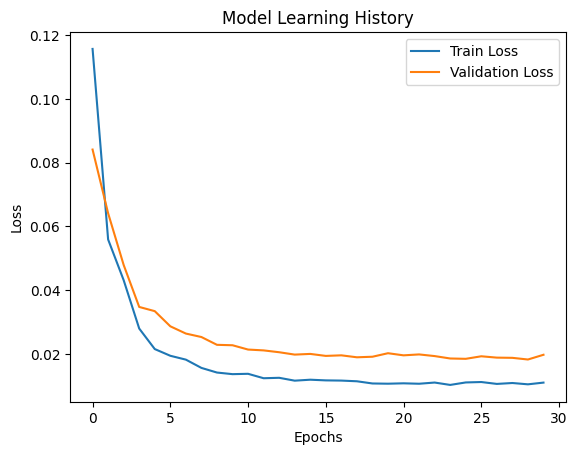

In [109]:
lstm_model_final = build_lstm_model(input_shape)
train_and_plot_model(lstm_model_final, X_final, y_final, epochs=30)

In [110]:
lstm_model_final.save("../models/lstm_model_final.h5")

In [111]:
joblib.dump(stands_scaler, '../models/scalers/stands_scaler.joblib')
joblib.dump(other_scaler, '../models/scalers/other_scaler.joblib')

['../models/scalers/other_scaler.joblib']